In [1]:
import math
from glob import glob
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
# from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures


In [2]:
sns.set_theme(style="whitegrid", font="Verdana")


In [3]:
%matplotlib inline


# Functions

In [4]:
def show_heatmap(X: pd.DataFrame) -> None:
    """Plots heatmap of a dataset.

    Parameters
    ----------
    X : pd.DataFrame
        data frame
    """
    figure = plt.figure(figsize=(12, 12), dpi=120)
    subplot = figure.add_subplot()
    
    sns.heatmap(X.corr(method="spearman"), annot=True, linewidths=0.5, square=True)

    plt.show()


In [5]:
def show_boxplot(X: pd.DataFrame) -> None:
    """Plots boxplots of each feature in a dataset.

    Parameters
    ----------
    X : pd.DataFrame
        data frame
    """
    columns = 4
    rows = math.ceil(X.shape[1] / columns)

    figure = plt.figure(figsize=(rows * columns * 2, rows * columns * 2), dpi=120)
    figure.subplots_adjust(wspace=0.4, hspace=0.2)

    for index, column in enumerate(iterable=X.columns):
        subplot = figure.add_subplot(rows, columns, index + 1)

        boxplot = subplot.boxplot(x=column, data=X)
        subplot.set_title(label=column)

    plt.show()


In [6]:
def show_pairplot(X: pd.DataFrame, target_label: str, alpha: int = 0.1) -> None:
    """Plots pair plots of a dataset.

    Parameters
    ----------
    X : pd.DataFrame
        data frame
    target_label : str
        target column label
    alpha : float = 0.01
        transparency coefficient
    """
    row_index = 1

    rows = math.ceil(X.shape[1] / 2) + 1
    columns = 3

    plot_color = "red"
    mean_color = "lightgray"

    data_frame_columns = X.columns[:-1]

    figure = plt.figure()

    figure.subplots_adjust(wspace=0.4, hspace=0.4)
    figure.set_size_inches(w=16, h=32)
    figure.set_dpi(val=120)

    for index in range(len(data_frame_columns)):
        index *= 2

        if index + 1 < len(data_frame_columns):
            subplot = figure.add_subplot(rows, columns, row_index)
            subplot.set(
                xlabel=data_frame_columns[index], ylabel=data_frame_columns[index + 1]
            )
            subplot.grid(False)
            subplot.scatter(
                x=X[data_frame_columns[index]],
                y=X[data_frame_columns[index + 1]],
                c=plot_color,
                alpha=alpha,
            )
            subplot.axvline(x=np.mean(X[data_frame_columns[index]]), c=mean_color)
            subplot.axhline(y=np.mean(X[data_frame_columns[index + 1]]), c=mean_color)

            subplot = figure.add_subplot(rows, columns, row_index + 2)
            subplot.set(xlabel=data_frame_columns[index + 1], ylabel=target_label)
            subplot.grid(False)
            subplot.scatter(
                x=X[data_frame_columns[index + 1]],
                y=X[target_label],
                c=plot_color,
                alpha=alpha,
            )
            subplot.axvline(x=np.mean(X[data_frame_columns[index + 1]]), c=mean_color)

        if index < len(data_frame_columns):
            subplot = figure.add_subplot(rows, columns, row_index + 1)
            subplot.set(xlabel=data_frame_columns[index], ylabel=target_label)
            subplot.grid(False)
            subplot.scatter(
                x=X[data_frame_columns[index]],
                y=X[target_label],
                c=plot_color,
                alpha=alpha,
            )
            subplot.axvline(x=np.mean(X[data_frame_columns[index]]), c=mean_color)

        row_index += columns

    # Lines indicate mean values
    plt.show()


In [7]:
def show_linear_metrics(y_true: np.array, y_pred: np.array) -> None:
    """Prints linear metrics.

    Parameters
    ----------
    y_true : np.array
        y true
    y_pred : np.array
        y predicted
    """
    print("Mean Absolute Error:", mean_absolute_error(y_true=y_true, y_pred=y_pred))
    print("Mean Squared Error", mean_squared_error(y_true=y_true, y_pred=y_pred))
    print(
        "Root Mean Squared Error:",
        mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False),
    )
    print("R^2 Score", r2_score(y_true=y_true, y_pred=y_pred))

    return pd.DataFrame(data={"Actual": y_true, "Predicted": y_pred}).reset_index(
        drop=True
    )


# [Dataset](https://drive.google.com/drive/folders/1nfrYxDm7TLzls9pedZbLX5rP4McVDWDe)

In [8]:
DATASET_PATH = "SSD2022AS2"


In [9]:
csv_files = glob(pathname=path.join(DATASET_PATH, "*.csv"), recursive=True)


In [10]:
dfs = list()

for csv_file in csv_files:
    dfs.append(pd.read_csv(filepath_or_buffer=csv_file))


In [11]:
df = pd.concat(objs=dfs).reset_index(drop=True)


In [12]:
df.timestamp = pd.to_datetime(df.timestamp)


# Stream Quality

# Next Session Time

In [13]:
df = df.groupby(by=["client_user_id", "session_id"]).aggregate(
    {
        "dropped_frames": [np.mean, np.std, np.max],
        "FPS": [np.mean, np.std],
        "bitrate": [np.mean, np.std],
        "RTT": [np.mean, np.std],
        "timestamp": [np.ptp],
    }
)


In [14]:
df.columns = ["_".join(column).lower() for column in df.columns.to_flat_index()]


In [15]:
df = df.reset_index(drop=True)


In [16]:
df.timestamp_ptp = df.timestamp_ptp.dt.total_seconds()


In [17]:
df = df.drop_duplicates()


In [18]:
# df.to_csv(path_or_buf="output.csv")


In [19]:
# ProfileReport(df=df).to_file(output_file="df.html")


# Data Engineering

In [20]:
df.describe()


,dropped_frames_mean,dropped_frames_std,dropped_frames_amax,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_ptp
count,4.282000e+03,4.271000e+03,4.282000e+03,4282.000000,4271.000000,4282.000000,4271.000000,4282.000000,4271.000000,4282.000000
mean,2.591464e+05,6.080102e+05,3.168871e+06,32.477122,4.966321,6119.307007,2906.126261,77.756632,94.916235,4778.179589
std,9.028839e+06,1.618685e+07,7.223703e+07,10.088129,4.853093,4992.881843,2273.756675,125.891218,285.949036,5936.363825
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,27.297028,1.960906,2144.764640,1227.177982,19.078351,3.637369,1077.500000
50%,2.611425e-02,9.483725e-01,3.100000e+01,29.310317,3.574199,4946.960085,2360.359319,38.254994,11.635649,3010.000000
75%,4.751437e-01,5.107822e+00,6.700000e+01,36.820229,6.958262,8933.872698,4050.548469,85.256332,47.051631,6070.000000
max,4.131929e+08,6.069961e+08,1.952806e+09,90.781818,153.371647,40130.270531,19533.922478,2486.860000,6448.922735,98350.000000


In [21]:
df.isna().sum()


dropped_frames_mean     0
dropped_frames_std     11
dropped_frames_amax     0
fps_mean                0
fps_std                11
bitrate_mean            0
bitrate_std            11
rtt_mean                0
rtt_std                11
timestamp_ptp           0
dtype: int64

In [22]:
df[df.isna().any(axis=1)]


,dropped_frames_mean,dropped_frames_std,dropped_frames_amax,fps_mean,fps_std,bitrate_mean,bitrate_std,rtt_mean,rtt_std,timestamp_ptp
450,0.0,NaN,0.0,30.0,NaN,10210.0,NaN,13.0,NaN,0.0
983,0.0,NaN,0.0,36.0,NaN,718.0,NaN,237.0,NaN,0.0
1016,0.0,NaN,0.0,5.0,NaN,1943.0,NaN,276.0,NaN,0.0
1035,0.0,NaN,0.0,5.0,NaN,1179.0,NaN,250.0,NaN,0.0
1062,0.0,NaN,0.0,0.0,NaN,1137.0,NaN,271.0,NaN,0.0
1959,0.0,NaN,0.0,23.0,NaN,5792.0,NaN,0.0,NaN,0.0
1994,0.0,NaN,0.0,29.0,NaN,4790.0,NaN,25.0,NaN,0.0
3289,0.0,NaN,0.0,24.0,NaN,4010.0,NaN,29.0,NaN,0.0
3508,0.0,NaN,0.0,30.0,NaN,0.0,NaN,0.0,NaN,0.0
3676,0.0,NaN,0.0,37.0,NaN,14.0,NaN,65.0,NaN,0.0


In [23]:
# df[:] = SimpleImputer().fit_transform(X=df)

df = df.replace(to_replace=np.nan, value=0)


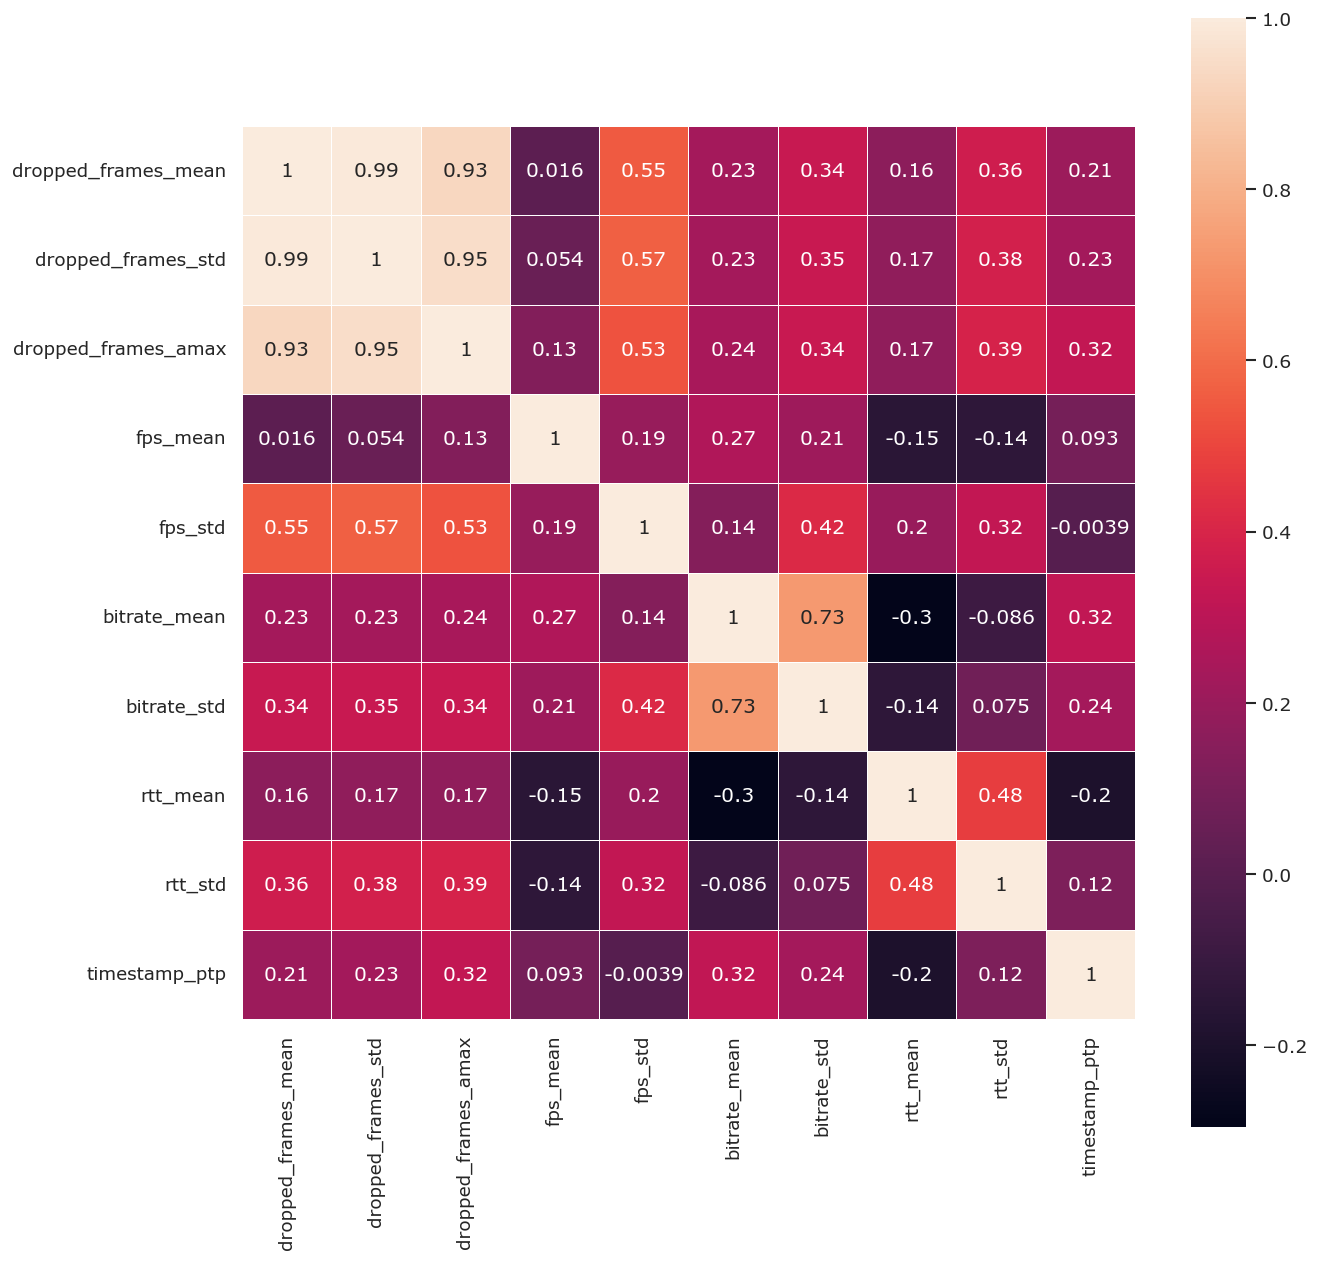

In [24]:
show_heatmap(X=df)


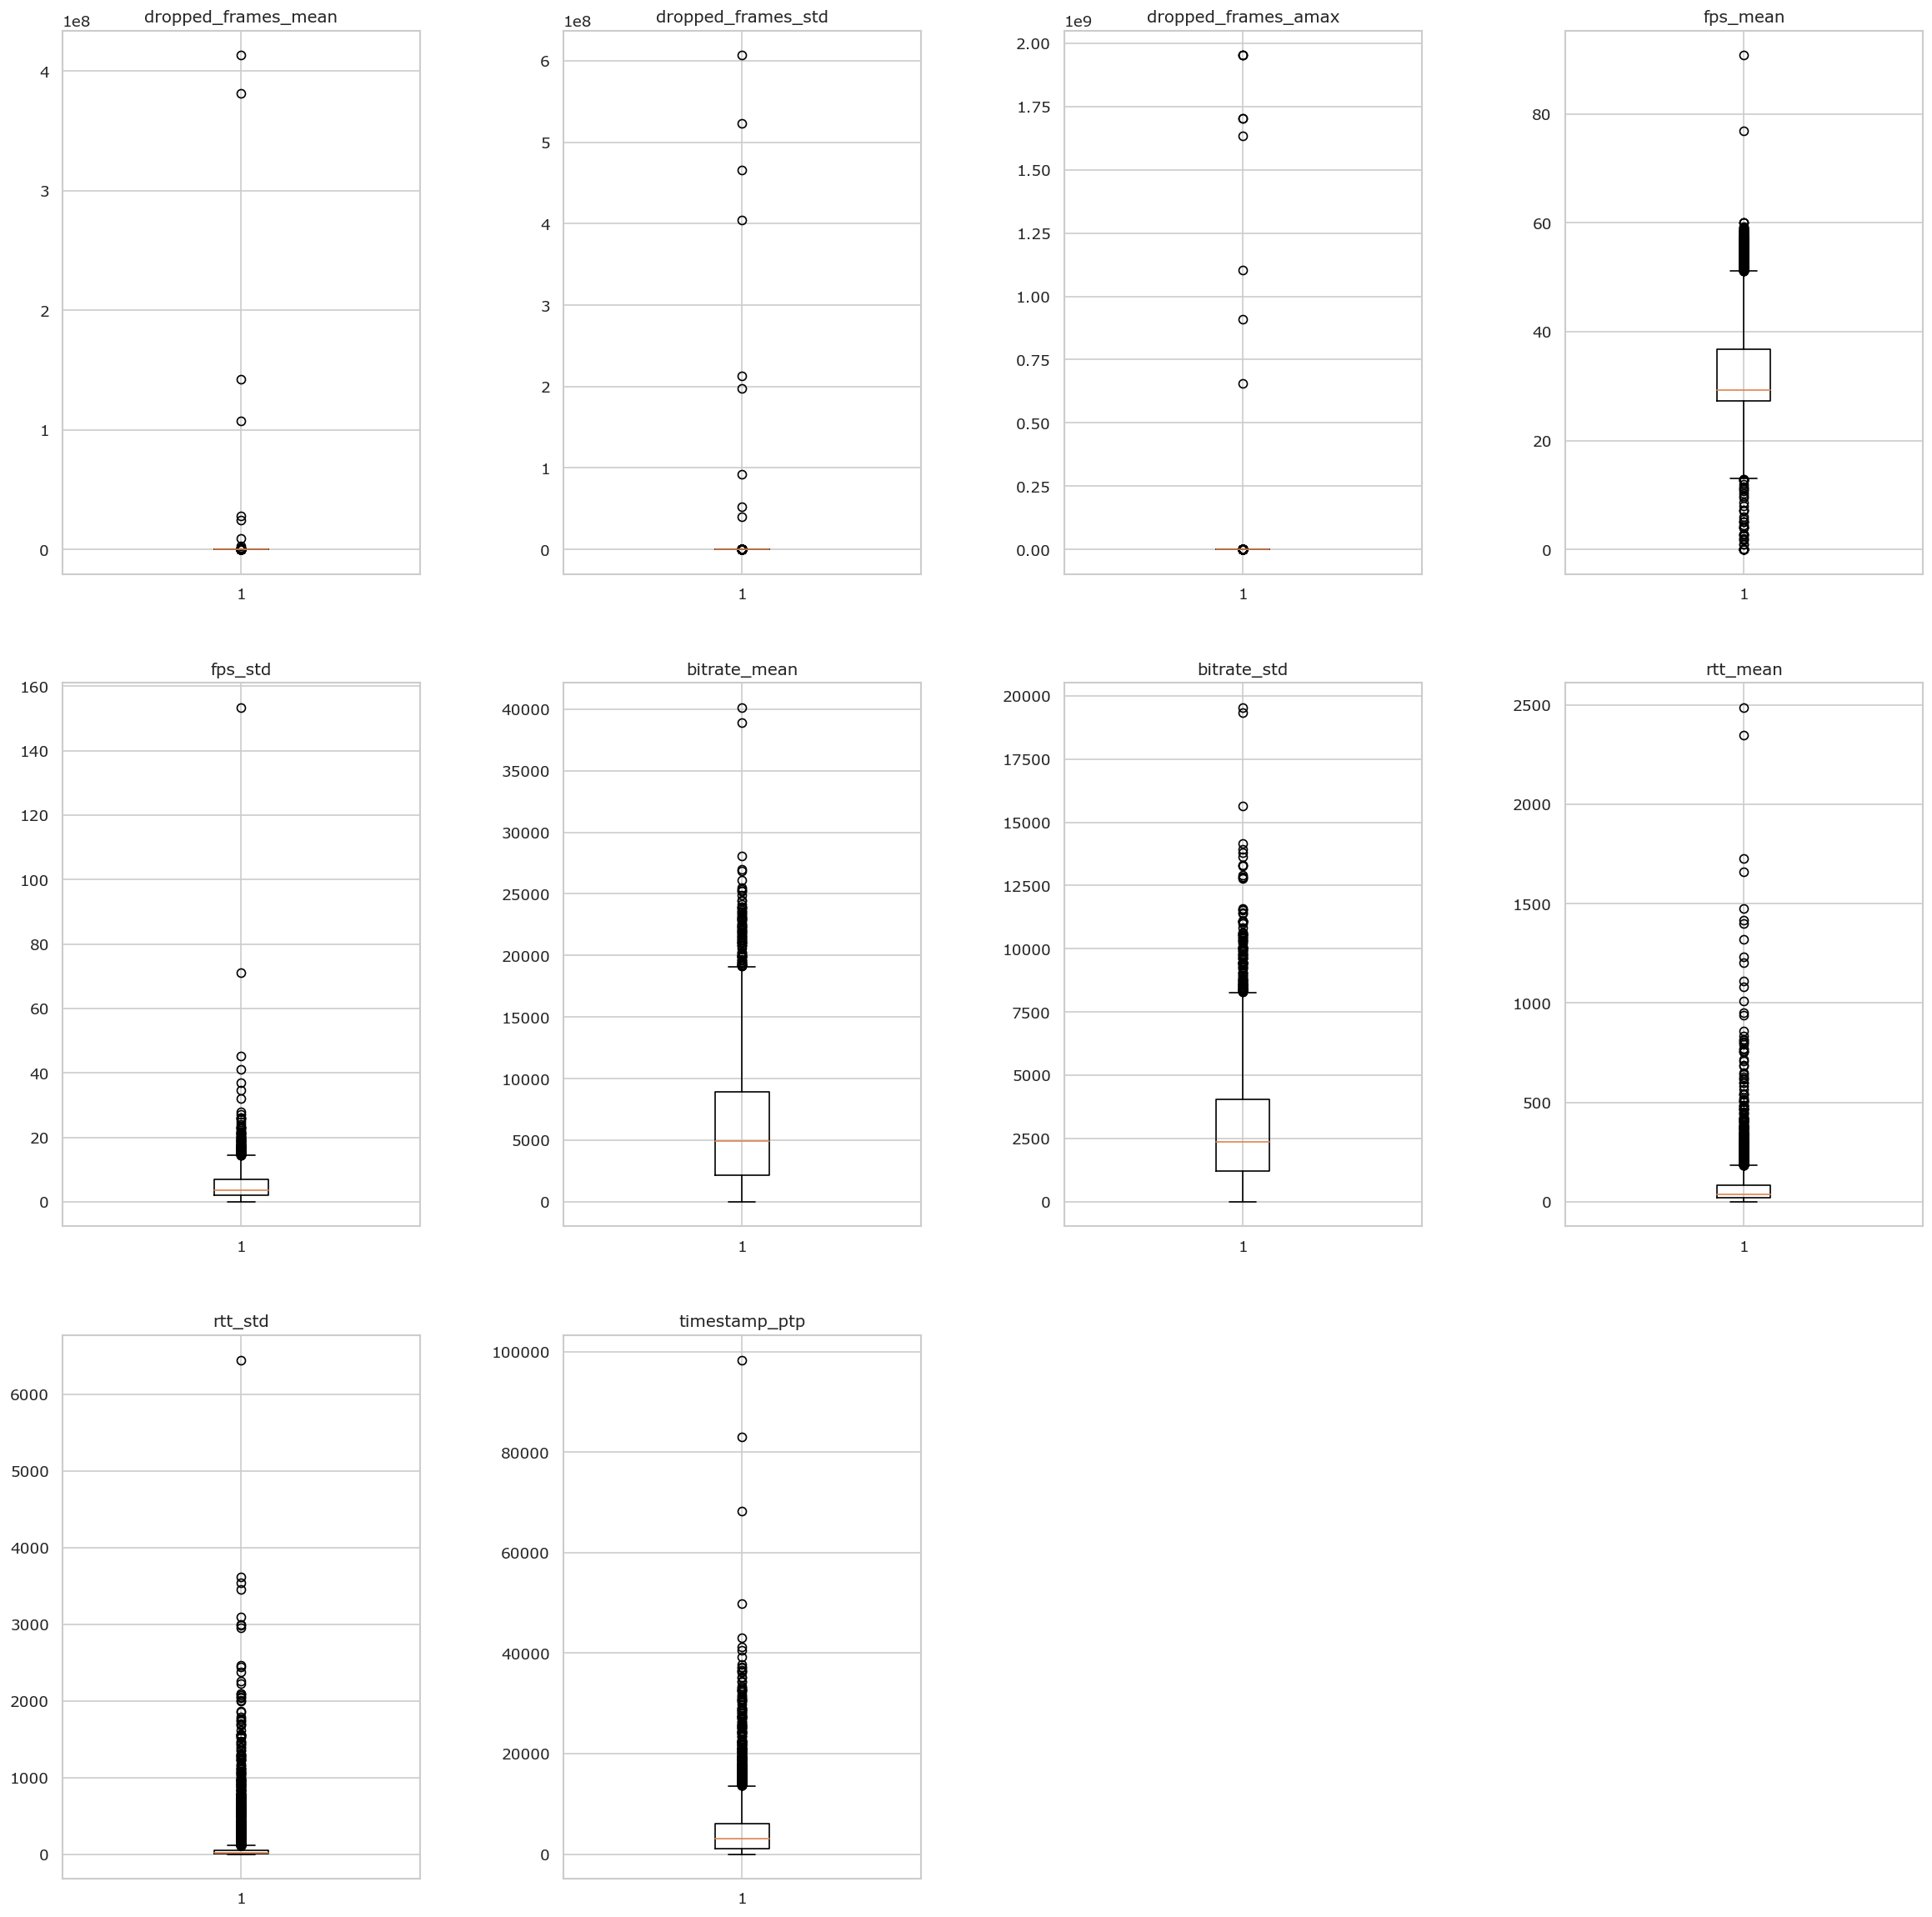

In [25]:
show_boxplot(X=df)


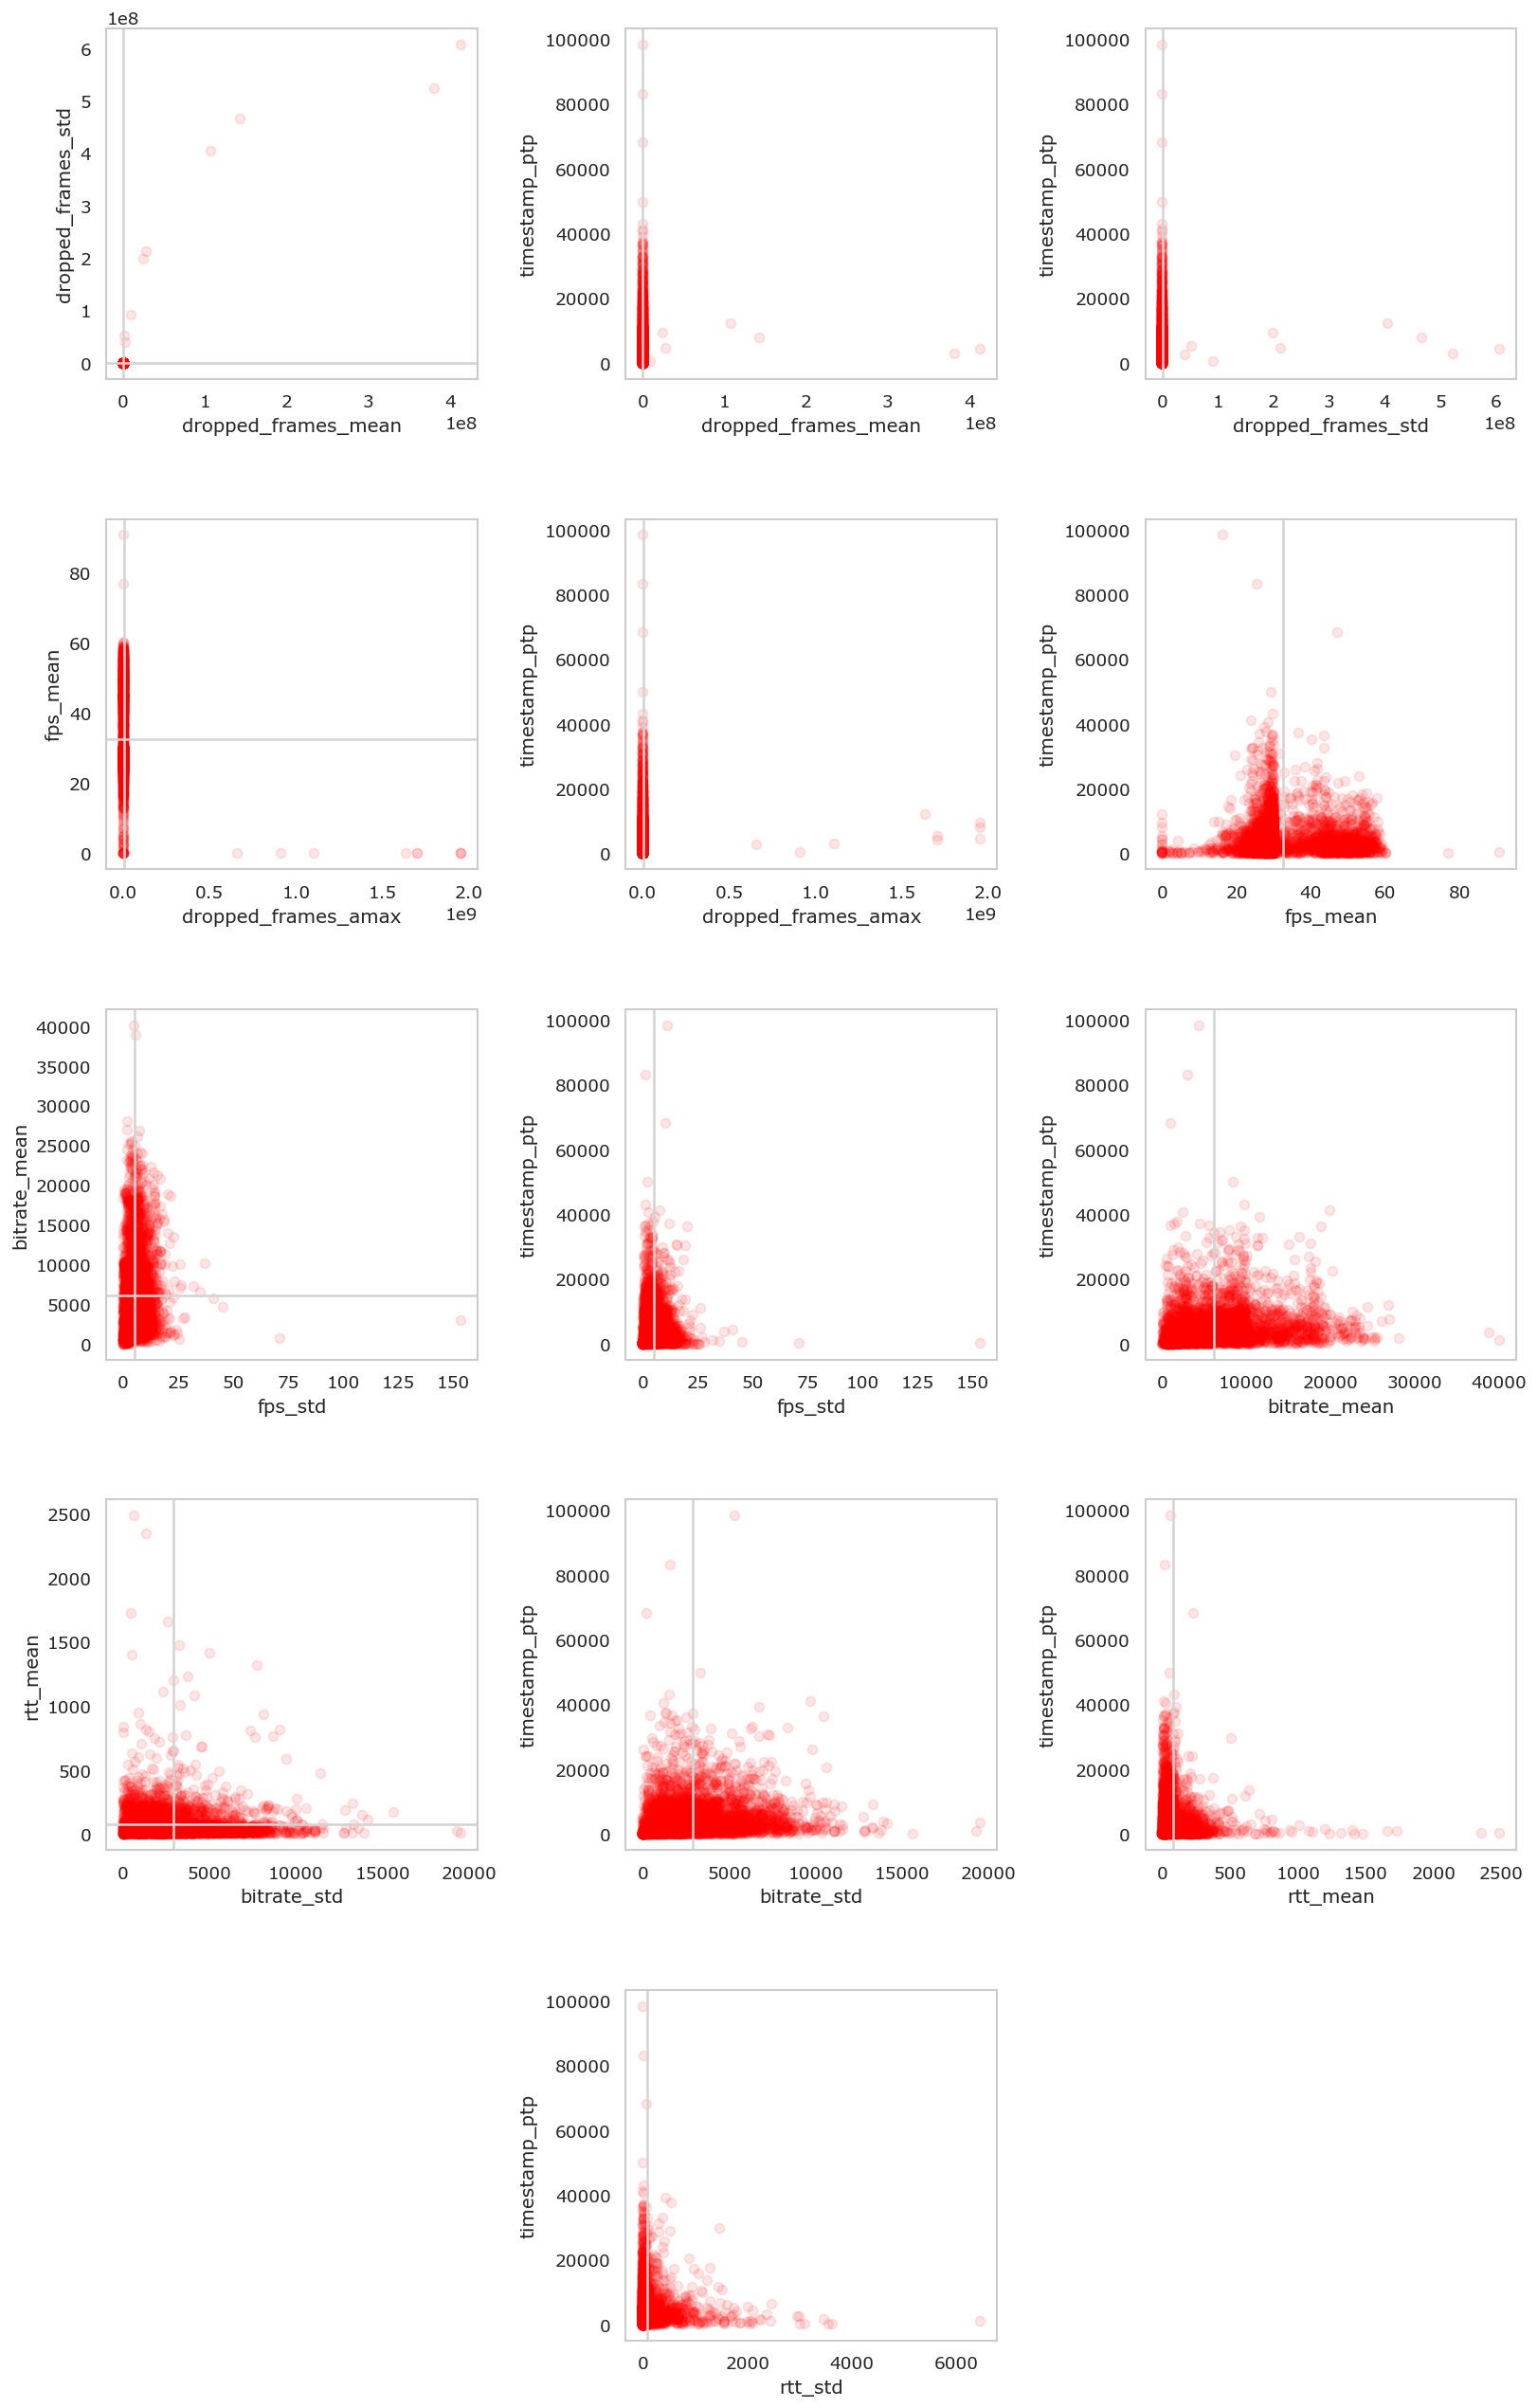

In [26]:
show_pairplot(X=df, target_label="timestamp_ptp")


In [27]:
df[df.columns[:-1]] = MinMaxScaler().fit_transform(X=df[df.columns[:-1]])


# Split

In [28]:
df_train, df_test = train_test_split(df, test_size=0.1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [29]:
# Outliers
# quantile = df_train.quantile(q=0.75)
# coef = 50

# for column in df_train.columns:
#     df_train = df_train.query(f"{column} < {quantile[column] * coef}")


In [30]:
df_train.shape


(3853, 10)

In [31]:
# X = X.drop(labels=["fps_mean", "fps_std", "rtt_mean", "rtt_std"], axis=1)


In [32]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train = df_train.drop(labels=["timestamp_ptp"], axis=1)
X_test = df_test.drop(labels=["timestamp_ptp"], axis=1)

y_train = df_train.timestamp_ptp
y_test = df_test.timestamp_ptp


# Model

In [33]:
# pipeline = make_pipeline(PolynomialFeatures(), LassoCV(max_iter=10000))

# param_grid = {"polynomialfeatures__degree": np.arange(2, 5)}

# polynomial_regression = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring="r2",
#     cv=10,
#     return_train_score=True,
# )
# polynomial_regression.fit(X=X_train, y=y_train)

# y_pred = polynomial_regression.predict(X=X_test)

# print("Degree:", polynomial_regression.best_params_["polynomialfeatures__degree"])


In [34]:
pipeline = make_pipeline(PolynomialFeatures(degree=2), LassoCV(max_iter=10000))
pipeline.fit(X=X_train, y=y_train)

y_pred = pipeline.predict(X=X_test)


In [35]:
# model = RidgeCV()
# y_pred = model.fit(X=X_train, y=y_train).predict(X=X_test)


In [36]:
show_linear_metrics(y_true=y_test, y_pred=y_pred)


Mean Absolute Error: 3595.981363620735
Mean Squared Error 28354863.421749864
Root Mean Squared Error: 5324.928489824992
R^2 Score 0.1138133289243386


,Actual,Predicted
0,8360.0,6402.466825
1,3475.0,6267.435839
2,9465.0,6330.590474
3,4860.0,5553.004365
4,265.0,3129.971091
...,...,...
424,150.0,4367.135299
425,4615.0,4603.656540
426,1090.0,3543.989723
427,10875.0,5950.851029


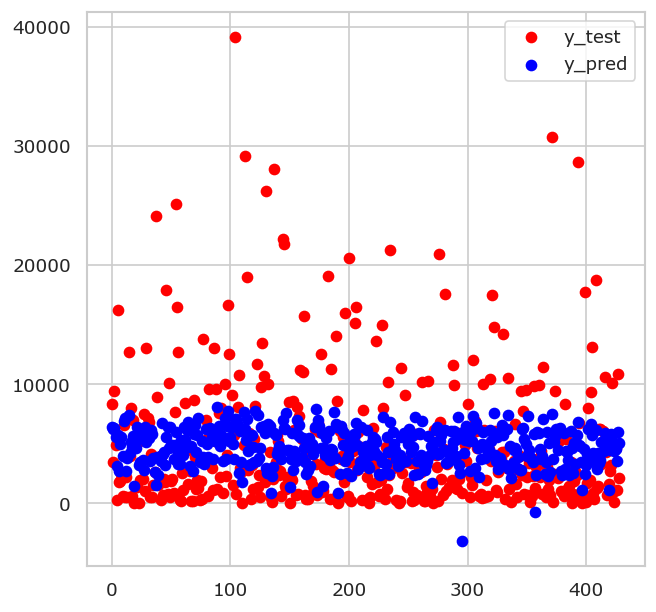

In [37]:
figure = plt.figure(figsize=(6, 6), dpi=120)
subplot = figure.add_subplot()

subplot.scatter(x=np.arange(len(y_test)), y=y_test, c="red", label="y_test")
subplot.scatter(x=np.arange(len(y_pred)), y=y_pred, c="blue", label="y_pred")

plt.legend()
plt.show()


# Total Number of Bad Sessions